<a href="https://colab.research.google.com/github/Mohamadaminlotfi98/Gradient-based-spike-detection-and-clustering-woth-Transformer-Autoencoder/blob/main/CWT_CNN_Spike_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive

Mounted at /gdrive
/gdrive/MyDrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as t
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pymatreader import read_mat
data = read_mat('Simulator/C_Easy1_noise005.mat')

In [ ]:
spike_class = data['spike_class'][0][:]
spike_data = data['data']
groundtruth_spike_time = data['spike_times']

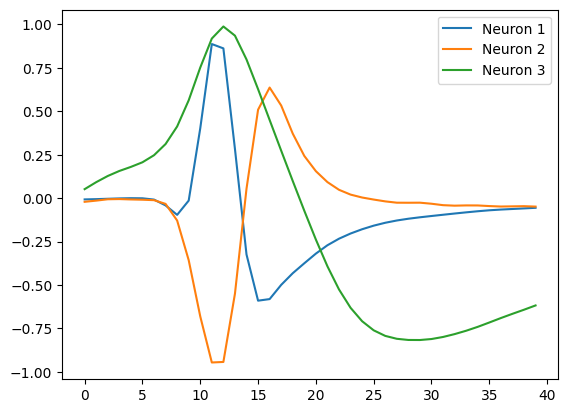

In [ ]:
# Define the waveform length (in samples)
waveform_length = 40
forward = 10
all_waveforms = np.zeros((len(groundtruth_spike_time), waveform_length))
# Loop through each spike
for i, spike_time in enumerate(groundtruth_spike_time):
    # Get the waveform around the spike time
    waveform = data['data'][spike_time+forward : spike_time + waveform_length+forward]
    # Store the waveform in the array
    all_waveforms[i] = waveform
unique_labels = np.unique(spike_class)
mean_waveforms = []
for label in unique_labels:
    mean_waveform = np.mean(all_waveforms[spike_class == label], axis=0)
    mean_waveforms.append(mean_waveform)

# Plot mean waveforms
for i, waveform in enumerate(mean_waveforms):
    plt.plot(waveform, label=f'Neuron {i+1}')
plt.legend()
plt.show()



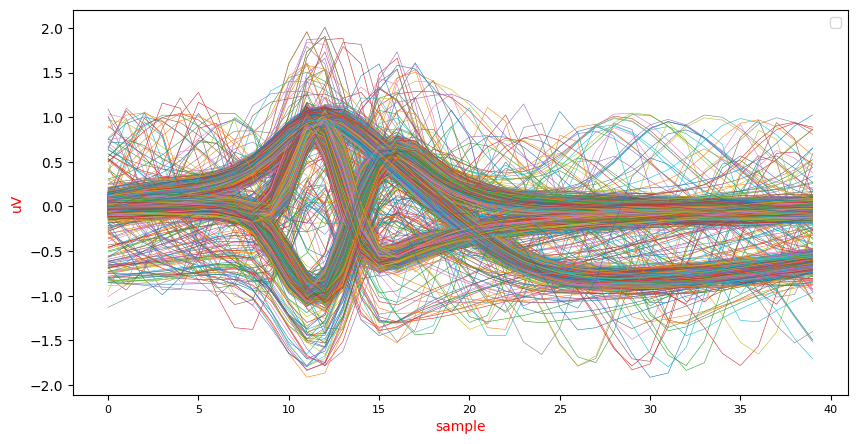

In [ ]:
plt.figure(figsize=(10,5))
for spike in all_waveforms :
        plt.plot(spike, linewidth=0.4)
        # Only show the label for the first spike in the cluster
        label = None
plt.xticks(fontsize=8)
plt.xlabel('sample', color='red')
plt.ylabel('uV', color='red')
plt.legend()
plt.show()

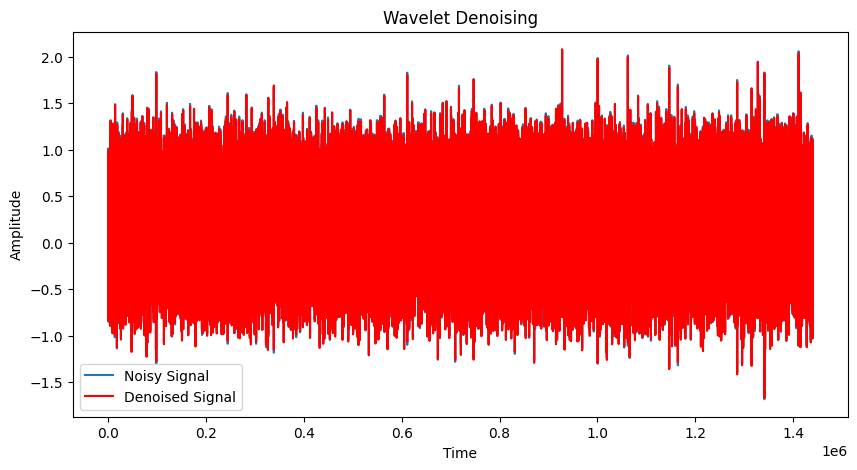

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
def wavelet_denoise(signal, wavelet='db4', level=1, mode='soft', threshold_type='soft'):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    for i in range(1, len(coeffs)):
        threshold = np.sqrt(2 * np.log(len(signal))) * np.median(np.abs(coeffs[i])) / 0.6745
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode=mode)
    denoised_signal = pywt.waverec(coeffs, wavelet, mode='periodic')
    return denoised_signal
signal = data['data']
denoised_signal = wavelet_denoise(signal)
plt.figure(figsize=(10, 5))
plt.plot(signal, label='Noisy Signal')
plt.plot(denoised_signal, color='red', label='Denoised Signal')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Wavelet Denoising')
plt.show()


number of detected spikes: (3520, 40)


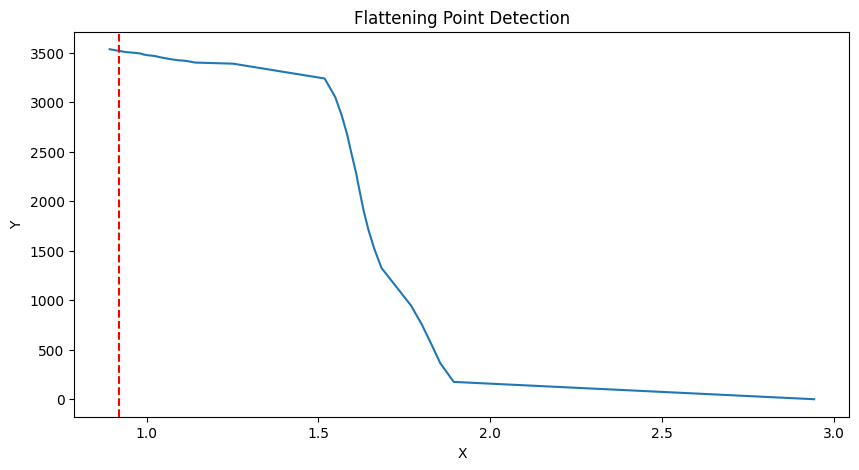

In [ ]:
from scipy.signal import find_peaks
spike_data = data['data']
maxima, _ = find_peaks(spike_data)
minima, _ = find_peaks(-spike_data)
peaks = np.concatenate((maxima, minima))
peaks = np.sort(peaks)
amplitudes = spike_data[peaks]
differences = np.abs(np.diff(amplitudes))
differences = differences[differences >= np.std(data['data'])]
x = np.linspace(60, 100 ,40)
tresholds = []
for i in x:
  iqr = np.percentile(differences,i)
  tresholds.append(iqr)
#threshold_values =  np.linspace(np.std(data['data']), 4*np.std(data['data']) ,20)
threshold_values = tresholds
num_spikes = []
for threshold in threshold_values:
    window_size = 50
    step = 10
    spike_times = []
    spike_amplitudes = []
    for i in range(0, len(spike_data) - window_size + 1, step):
        window_data = spike_data[i:i+window_size]
        window_maxima, _ = find_peaks(window_data)
        window_minima, _ = find_peaks(-window_data)
        window_peaks = np.concatenate((window_maxima, window_minima))
        window_peaks = np.sort(window_peaks)
        if len(window_peaks) > 0:
            window_amplitudes = window_data[window_peaks]
            window_differences = np.abs(np.diff(window_amplitudes))
            if window_differences.size > 0 and np.max(window_differences) > threshold:
                max_window_differences_index = np.argmax(window_differences)
                peak = window_peaks[max_window_differences_index]
                spike_time = i + peak
                spike_amplitude = window_amplitudes[max_window_differences_index]
                if len(spike_times) == 0 or spike_time - spike_times[-1] >= 20:
                    spike_times.append(spike_time)
                    spike_amplitudes.append(spike_amplitude)
                elif spike_time - spike_times[-1] < 20 and spike_amplitude > spike_amplitudes[-1]:
                    spike_times[-1] = spike_time
                    spike_amplitudes[-1] = spike_amplitude
    num_spikes.append(len(spike_times))
x = threshold_values
y = num_spikes
x_std = (x - np.mean(x)) / np.std(x)
y_std = (y - np.mean(y)) / np.std(y)
dydx = np.gradient(y_std, x_std)
flattening_idx = np.argmax(np.abs(dydx) <= 1 ) + 1
selected_treshold = threshold_values[flattening_idx]
spike_times = []
spike_waveforms = []
for i in range(0, len(spike_data) - window_size + 1, step):
    window_data = spike_data[i:i+window_size]
    window_maxima, _ = find_peaks(window_data)
    window_minima, _ = find_peaks(-window_data)
    window_peaks = np.concatenate((window_maxima, window_minima))
    window_peaks = np.sort(window_peaks)
    if len(window_peaks) > 0:
        window_amplitudes = window_data[window_peaks]
        window_differences = np.abs(np.diff(window_amplitudes))
        if window_differences.size > 0 and np.max(window_differences) > selected_treshold:
            max_window_differences_index = np.argmax(window_differences)
            peak = window_peaks[max_window_differences_index]
            spike_time = i + peak
            spike_amplitude = window_amplitudes[max_window_differences_index]
            if len(spike_times) == 0 or spike_time - spike_times[-1] >= 20:
                spike_times.append(spike_time)
                spike_amplitudes.append(spike_amplitude)
            elif spike_time - spike_times[-1] < 20 and spike_amplitude > spike_amplitudes[-1]:
                spike_times[-1] = spike_time
                spike_amplitudes[-1] = spike_amplitude
spike_times = np.array(spike_times)
forward_cut = 25
backward_cut = 15
spike_waveforms = []
for i in spike_times:
    selected_waveform = data['data'][i - backward_cut : i + forward_cut ]
    spike_waveforms.append(selected_waveform)
spike_waveforms = np.array(spike_waveforms)
# Plot the data and the identified point
print("number of detected spikes:",spike_waveforms.shape)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y)
ax.axvline(x=x[flattening_idx], color='r', linestyle='--')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Flattening Point Detection')
plt.show()

In [ ]:
deviation = 30
pred_spike_times = spike_times
gt_spike_times = (groundtruth_spike_time)
tp = 0
fp = 0
fn = 0
for pred_time in pred_spike_times:
    is_true_positive = False
    for gt_time in gt_spike_times:
        if abs(pred_time - gt_time) <= deviation:
            tp += 1
            is_true_positive = True
            break
    if not is_true_positive:
        fp += 1
for gt_time in gt_spike_times:
    is_false_negative = True
    for pred_time in pred_spike_times:
        if abs(pred_time - gt_time) <= deviation:
            is_false_negative = False
            break
    if is_false_negative:
        fn += 1
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
# Print the results
print('nubmer of existence spikes:',all_waveforms.shape)
print('Number of true positives:', tp)
print('Number of false positives:', fp)
print('Number of false negatives:', fn)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)

nubmer of existence spikes: (3514, 40)
Number of true positives: 3484
Number of false positives: 36
Number of false negatives: 23
Precision: 0.9897727272727272
Recall: 0.9934416880524665
F1-score: 0.9916038138608226


In [ ]:
# import torch.nn.functional as F
# class TransformerSpikeSorter(nn.Module):
#     def __init__(self, input_size):
#         super(TransformerSpikeSorter, self).__init__()
#         self.input_size = input_size
#         self.transformer_encoder = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(d_model=input_size, nhead=10, dim_feedforward=128),num_layers=2)
#         # self.fc1 = nn.Linear(40*40,512)
#         # self.fc2 = nn.Linear(512,64)
#         # self.fc3 = nn.Linear(64,512)
#         # self.fc4 = nn.Linear(512,40*40)
#         self.transformer_decoder = nn.TransformerDecoder(
#             nn.TransformerDecoderLayer(d_model=input_size, nhead=10, dim_feedforward=128),num_layers=2)
#         self.relu = nn.ReLU()
#     def forward(self, x):
#         encoded  = (self.transformer_encoder(x))
#         # D1 = self.relu(self.fc1(encoded.view(-1,40*40)))
#         # D2 = self.fc2(D1)
#         # D3 = self.relu(self.fc3(self.relu(D2)))
#         # D4 = self.relu(self.fc4(D3))
#         # decode = D4.view(-1,40,40)
#         output = self.transformer_decoder(x, encoded)
#         return output
# input_size = 40
# Transformer = TransformerSpikeSorter(input_size)

In [ ]:
class SpikeAutoencoder(nn.Module):
    def __init__(self):
        super(SpikeAutoencoder, self).__init__()
        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Define the decoder layers
        self.decoder = nn.Sequential(
              nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1),
              nn.ReLU(),
              nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=5, stride=2, padding=1),
              nn.ReLU(),
              nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2, padding=1),
              # nn.ReLU(),
              # nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=6, stride=2, padding=2),
              # nn.ReLU()
)

    def forward(self, x):
        encoded = self.encoder(x)
        # flattened = torch.squeeze(encoded,dim=1)
        # flattened = torch.unsqueeze(flattened,dim=0)
        print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded

Transformer = SpikeAutoencoder()

In [ ]:
class SpikeAutoencoder(nn.Module):
    def __init__(self):
        super(SpikeAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # flattened = torch.squeeze(encoded,dim=1)
        # flattened = torch.unsqueeze(flattened,dim=0)
        decoded = self.decoder(encoded)
        return decoded

Transformer = SpikeAutoencoder()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device\n")
Transformer.to(device)

The model will be running on cpu device



SpikeAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
# Create a random input tensor
s = torch.rand([64,40,40])
print(Transformer(s).shape)

torch.Size([64, 40, 40])


In [ ]:
from scipy.fftpack import dct
import pywt
from scipy import signal
wavelet = np.zeros((len(all_waveforms), 40, 40))
scales = np.arange(1, 41)
for i in range(len(all_waveforms)):
    cwtmatr = signal.cwt(all_waveforms[i], signal.morlet, scales)
    wavelet[i, :, :] = cwtmatr
    # cwtmatr = signal.cwt(spike_curve[i], signal.ricker, scales)
    # wavelet[i, 1, :, :] = cwtmatr
    # # Compute DCT coefficients for each sample in the spike curve
    # dct_coefficients = dct(spike_curve[i], norm='ortho')
    # dct_coefficients_2d = np.tile(dct_coefficients, (50, 1)).T
    # wavelet[i, 2, :, :] = dct_coefficients_2d

<ipython-input-192-e4508e4e8e84>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  wavelet[i, :, :] = cwtmatr


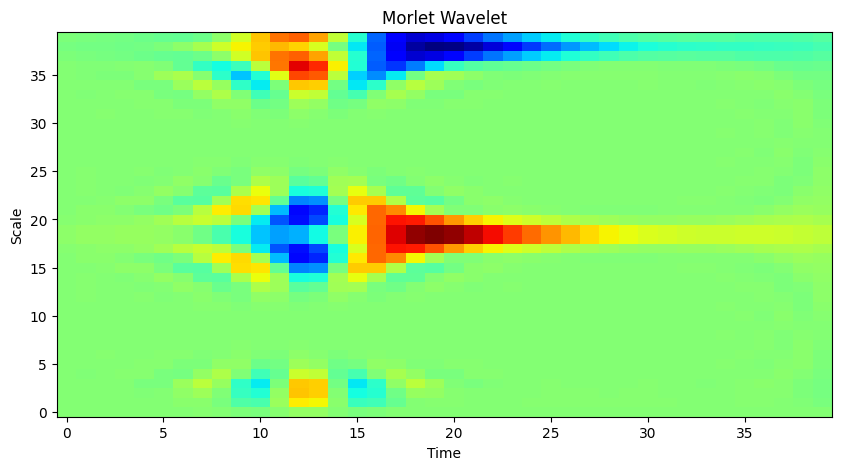

In [ ]:
spk = 589
morlet_coeffs =  wavelet[spk, :, :]
# ricker_coeffs =  wavelet[spk, 1, :, :]
# DCT_coeffs    =  wavelet[spk, 2, :, :]
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(morlet_coeffs, aspect='auto', cmap='jet', origin='lower')
axs.set_title('Morlet Wavelet')
axs.set_xlabel('Time')
axs.set_ylabel('Scale')
# axs[1].imshow(ricker_coeffs, aspect='auto', cmap='jet', origin='lower')
# axs[1].set_title('Rickle Wavelet')
# axs[1].set_xlabel('Time')
# axs[1].set_ylabel('Scale')
# axs[2].imshow(DCT_coeffs, aspect='auto', cmap='jet', origin='lower')
# axs[2].set_title('DCT Wavelet')
# axs[2].set_xlabel('Time')
# axs[2].set_ylabel('Scale')
plt.show()

In [ ]:
wavelet.shape

(3514, 40, 40)

In [ ]:
from torch.utils.data import DataLoader
spikes = wavelet
labels = spike_class
batch_size = 64
shuffle = True
spike_dataset = torch.utils.data.TensorDataset(torch.Tensor(spikes), torch.Tensor(labels).long())
spike_dataloader = DataLoader(spike_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

In [ ]:
from torch.optim import Adam
from tqdm import tqdm
num_epochs = 40
criterion = nn.MSELoss()
optimizer = Adam(Transformer.parameters(), lr=0.001)
for epoch in range(num_epochs):
    total_loss = 0.0
    progress_bar = tqdm(spike_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for batch,_ in progress_bar:
        inputs = batch
        optimizer.zero_grad()
        latent_values = Transformer(inputs)
        loss = criterion(latent_values,inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": total_loss / len(progress_bar)})
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(spike_dataloader):.4f}")

Epoch 1/40: 100%|██████████| 54/54 [00:01<00:00, 40.98batch/s, Loss=0.408]


Epoch 1/40, Loss: 0.4079


Epoch 2/40: 100%|██████████| 54/54 [00:01<00:00, 40.42batch/s, Loss=0.36]


Epoch 2/40, Loss: 0.3596


Epoch 3/40: 100%|██████████| 54/54 [00:01<00:00, 40.60batch/s, Loss=0.359]


Epoch 3/40, Loss: 0.3585


Epoch 4/40: 100%|██████████| 54/54 [00:01<00:00, 41.09batch/s, Loss=0.356]


Epoch 4/40, Loss: 0.3560


Epoch 5/40: 100%|██████████| 54/54 [00:01<00:00, 38.73batch/s, Loss=0.355]


Epoch 5/40, Loss: 0.3553


Epoch 6/40: 100%|██████████| 54/54 [00:01<00:00, 39.80batch/s, Loss=0.355]


Epoch 6/40, Loss: 0.3548


Epoch 7/40: 100%|██████████| 54/54 [00:01<00:00, 36.83batch/s, Loss=0.353]


Epoch 7/40, Loss: 0.3527


Epoch 8/40: 100%|██████████| 54/54 [00:01<00:00, 29.28batch/s, Loss=0.354]


Epoch 8/40, Loss: 0.3537


Epoch 9/40: 100%|██████████| 54/54 [00:01<00:00, 33.51batch/s, Loss=0.352]


Epoch 9/40, Loss: 0.3520


Epoch 10/40: 100%|██████████| 54/54 [00:01<00:00, 40.80batch/s, Loss=0.353]


Epoch 10/40, Loss: 0.3531


Epoch 11/40: 100%|██████████| 54/54 [00:01<00:00, 40.25batch/s, Loss=0.352]


Epoch 11/40, Loss: 0.3516


Epoch 12/40: 100%|██████████| 54/54 [00:01<00:00, 42.30batch/s, Loss=0.351]


Epoch 12/40, Loss: 0.3511


Epoch 13/40: 100%|██████████| 54/54 [00:01<00:00, 41.10batch/s, Loss=0.352]


Epoch 13/40, Loss: 0.3521


Epoch 14/40: 100%|██████████| 54/54 [00:01<00:00, 41.59batch/s, Loss=0.352]


Epoch 14/40, Loss: 0.3516


Epoch 15/40: 100%|██████████| 54/54 [00:01<00:00, 42.22batch/s, Loss=0.352]


Epoch 15/40, Loss: 0.3520


Epoch 16/40: 100%|██████████| 54/54 [00:01<00:00, 41.34batch/s, Loss=0.354]


Epoch 16/40, Loss: 0.3536


Epoch 17/40: 100%|██████████| 54/54 [00:01<00:00, 31.88batch/s, Loss=0.351]


Epoch 17/40, Loss: 0.3508


Epoch 18/40: 100%|██████████| 54/54 [00:01<00:00, 31.45batch/s, Loss=0.352]


Epoch 18/40, Loss: 0.3521


Epoch 19/40: 100%|██████████| 54/54 [00:01<00:00, 41.66batch/s, Loss=0.351]


Epoch 19/40, Loss: 0.3512


Epoch 20/40: 100%|██████████| 54/54 [00:01<00:00, 41.66batch/s, Loss=0.353]


Epoch 20/40, Loss: 0.3526


Epoch 21/40: 100%|██████████| 54/54 [00:01<00:00, 41.72batch/s, Loss=0.35]


Epoch 21/40, Loss: 0.3502


Epoch 22/40: 100%|██████████| 54/54 [00:01<00:00, 41.71batch/s, Loss=0.353]


Epoch 22/40, Loss: 0.3532


Epoch 23/40: 100%|██████████| 54/54 [00:01<00:00, 42.15batch/s, Loss=0.352]


Epoch 23/40, Loss: 0.3520


Epoch 24/40: 100%|██████████| 54/54 [00:01<00:00, 41.10batch/s, Loss=0.352]


Epoch 24/40, Loss: 0.3520


Epoch 25/40: 100%|██████████| 54/54 [00:01<00:00, 41.33batch/s, Loss=0.35]


Epoch 25/40, Loss: 0.3504


Epoch 26/40: 100%|██████████| 54/54 [00:01<00:00, 36.31batch/s, Loss=0.352]


Epoch 26/40, Loss: 0.3516


Epoch 27/40: 100%|██████████| 54/54 [00:01<00:00, 29.89batch/s, Loss=0.351]


Epoch 27/40, Loss: 0.3508


Epoch 28/40: 100%|██████████| 54/54 [00:01<00:00, 37.11batch/s, Loss=0.35]


Epoch 28/40, Loss: 0.3499


Epoch 29/40: 100%|██████████| 54/54 [00:01<00:00, 42.17batch/s, Loss=0.352]


Epoch 29/40, Loss: 0.3524


Epoch 30/40: 100%|██████████| 54/54 [00:01<00:00, 41.90batch/s, Loss=0.351]


Epoch 30/40, Loss: 0.3513


Epoch 31/40: 100%|██████████| 54/54 [00:01<00:00, 41.55batch/s, Loss=0.348]


Epoch 31/40, Loss: 0.3483


Epoch 32/40: 100%|██████████| 54/54 [00:01<00:00, 41.58batch/s, Loss=0.351]


Epoch 32/40, Loss: 0.3508


Epoch 33/40: 100%|██████████| 54/54 [00:01<00:00, 41.69batch/s, Loss=0.349]


Epoch 33/40, Loss: 0.3493


Epoch 34/40: 100%|██████████| 54/54 [00:01<00:00, 41.59batch/s, Loss=0.351]


Epoch 34/40, Loss: 0.3508


Epoch 35/40: 100%|██████████| 54/54 [00:01<00:00, 38.54batch/s, Loss=0.349]


Epoch 35/40, Loss: 0.3488


Epoch 36/40: 100%|██████████| 54/54 [00:04<00:00, 12.43batch/s, Loss=0.35]


Epoch 36/40, Loss: 0.3496


Epoch 37/40: 100%|██████████| 54/54 [00:02<00:00, 20.74batch/s, Loss=0.351]


Epoch 37/40, Loss: 0.3510


Epoch 38/40: 100%|██████████| 54/54 [00:03<00:00, 17.03batch/s, Loss=0.352]


Epoch 38/40, Loss: 0.3523


Epoch 39/40: 100%|██████████| 54/54 [00:01<00:00, 27.56batch/s, Loss=0.35]


Epoch 39/40, Loss: 0.3499


Epoch 40/40: 100%|██████████| 54/54 [00:02<00:00, 19.40batch/s, Loss=0.35]

Epoch 40/40, Loss: 0.3496


In [ ]:
inputs.shape

torch.Size([58, 40, 40])

In [ ]:
# from torch.optim import Adam
# from tqdm import tqdm

# num_epochs = 20
# criterion = nn.MSELoss()
# optimizer = Adam(Transformer.parameters(), lr=0.001)
# num_inputs_per_update = 64
# total_loss = 0.0
# inputs_processed = 0

# for epoch in range(num_epochs):
#     progress_bar = tqdm(spike_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
#     for batch, _ in progress_bar:
#         inputs = batch
#         optimizer.zero_grad()
#         latent_values = Transformer(inputs)
#         loss = criterion(latent_values, inputs)
#         loss.backward()

#         total_loss += loss.item()
#         inputs_processed += inputs.size(0)

#         if inputs_processed >= num_inputs_per_update:
#             optimizer.step()
#             inputs_processed = 0
#             optimizer.zero_grad()

#         progress_bar.set_postfix({"Loss": total_loss / len(progress_bar)})

#     # Check if there are remaining inputs that haven't been updated
#     if inputs_processed > 0:
#         optimizer.step()
#         inputs_processed = 0
#         optimizer.zero_grad()

#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(spike_dataloader):.4f}")
#     total_loss = 0.0


In [ ]:
from torch.utils.data import DataLoader
spikes = wavelet
labels = spike_class
batch_size = 64
shuffle = False
spike_dataset = torch.utils.data.TensorDataset(torch.Tensor(spikes), torch.Tensor(labels).long())
spike_dataloader = DataLoader(spike_dataset, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
Transformer.eval()
latent_space = []
attention_weights = []
with torch.no_grad():
    for batch, _ in spike_dataloader:
        inputs = batch
        latent_values = Transformer.encoder(inputs)
        # latent_values = Transformer.fc1(latent_values)
        # latent_values = Transformer.fc2(latent_values)
        latent_space.append(latent_values.view(-1,16))
latent_space = torch.cat(latent_space, dim=0)
def perform_clustering(latent_space):
    k = 3
    kmeans = KMeans(n_clusters=k,n_init=10)  # You can change the number of clusters as needed
    kmeans.fit(latent_space)
    cluster_labels = kmeans.labels_
    #gmm = GaussianMixture(n_components=k)
    #cluster_labels = gmm.fit_predict(latent_space)
    return cluster_labels + 1
from sklearn.metrics import accuracy_score
def measure_accuracy(cluster_labels, ground_truth_labels):
    accuracy = accuracy_score(ground_truth_labels, cluster_labels)
    return accuracy
# Perform clustering using your desired clustering algorithm
cluster_labels = perform_clustering(latent_space)
ari = adjusted_rand_score(labels, cluster_labels)
print('Adjusted Rand Index:', ari)

In [ ]:
latent_space.shape

torch.Size([3514, 40, 40])

In [ ]:
from sklearn.decomposition import PCA
# Reshape the latent space tensor into a 2D array
latent_space_2d = latent_space.view(-1, 1600)
# Apply PCA to the 2D array
pca = PCA(n_components=40)
latent_space_pca = pca.fit_transform(latent_space_2d)

In [ ]:
latent_space_pca.shape

(3514, 40)

In [ ]:
cluster_labels = perform_clustering(latent_space_pca)
ari = adjusted_rand_score(labels, cluster_labels)
print('Adjusted Rand Index:', ari)

Adjusted Rand Index: 0.5230488088476045


In [ ]:
latent_space.shape

torch.Size([3514, 40, 40])

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

def perform_clustering(latent_space):
    pca = PCA(n_components=14)
    pca_latent_space = pca.fit_transform(latent_space)
    k = 3
    gmm = GaussianMixture(n_components=k)
    cluster_labels = gmm.fit_predict(pca_latent_space)
    return cluster_labels + 1
from sklearn.metrics import accuracy_score
def measure_accuracy(cluster_labels, ground_truth_labels):
    accuracy = accuracy_score(ground_truth_labels, cluster_labels)
    return accuracy
# Perform clustering using your desired clustering algorithm
cluster_labels = perform_clustering(all_waveforms)
ari = adjusted_rand_score(labels, cluster_labels)
print('Adjusted Rand Index:', ari)

Adjusted Rand Index: 0.5125417001287353


Label: 3


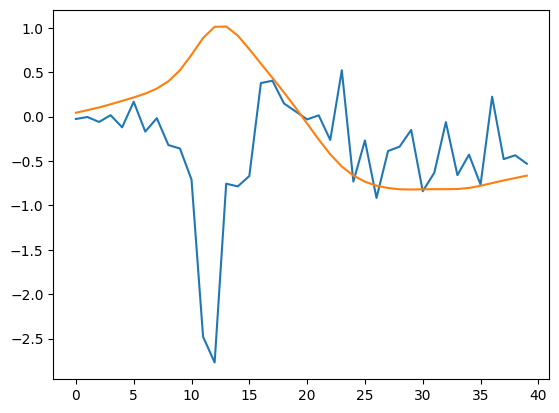

Label: 2


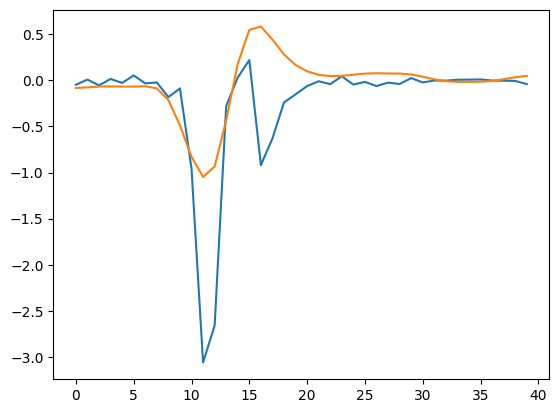

Label: 1


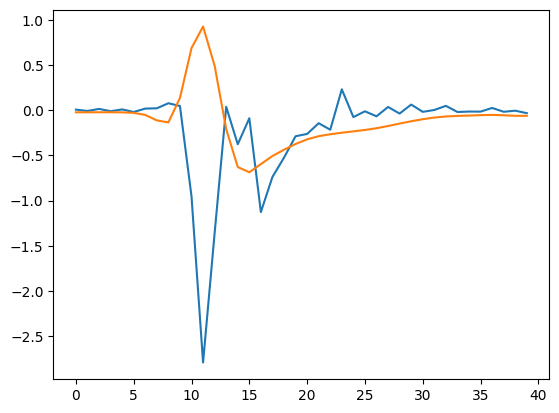

Label: 1


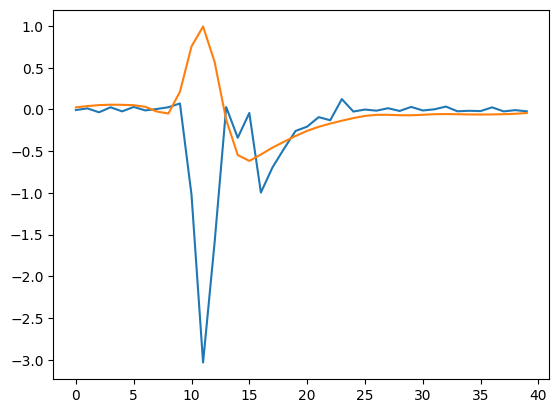

Label: 3


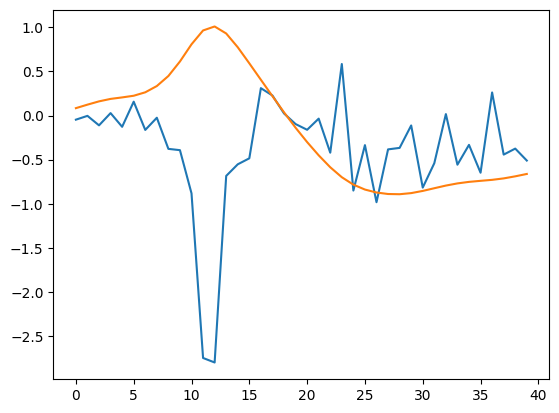

Label: 2


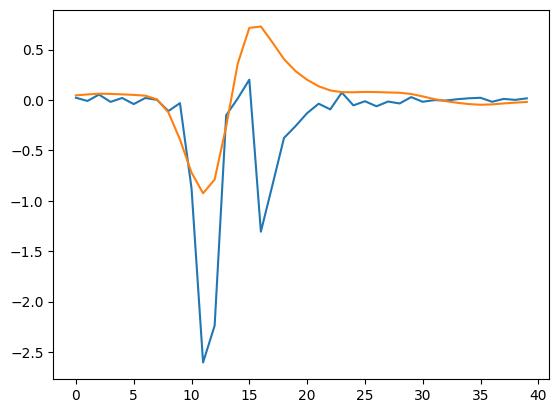

Label: 1


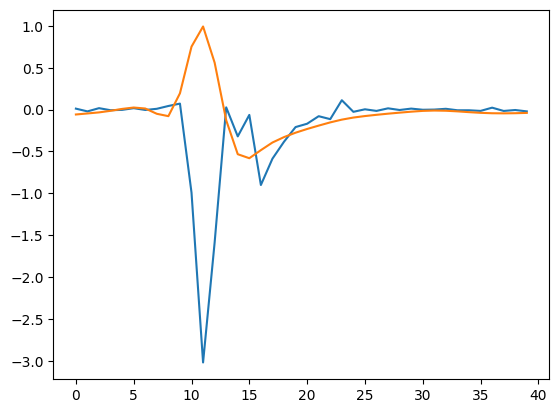

Label: 1


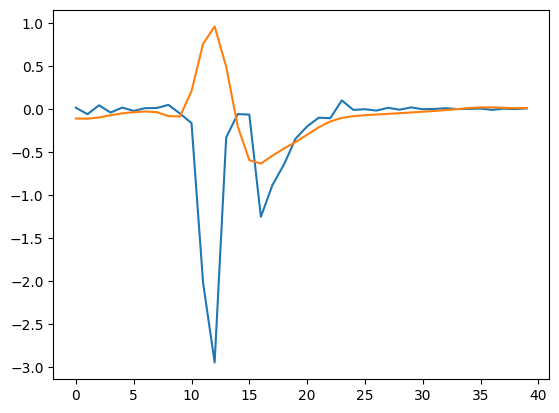

Label: 2


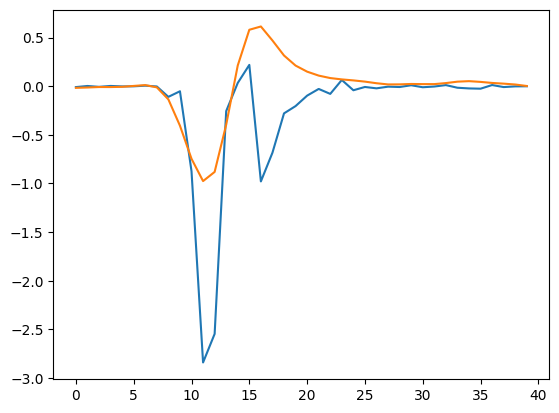

Label: 1


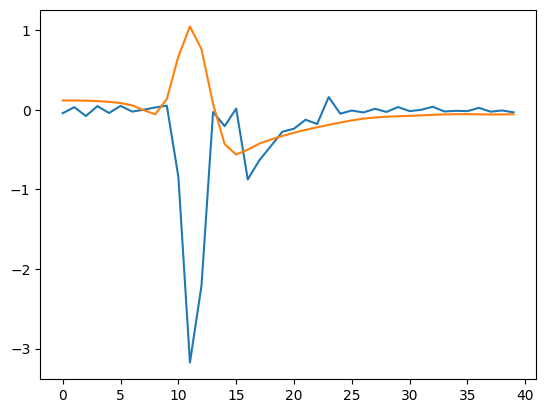

In [ ]:
import random
# Define the number of plots to display
num_plots = 10
# Generate random indices for the plots
plot_indices = random.sample(range(len(all_waveforms)), num_plots)
# Loop over the plots and display them
for i in range(num_plots):
    index = plot_indices[i]
    print(f"Label: {labels[index]}")
    plt.plot(new_domain[index])
    plt.plot(all_waveforms[index])
    plt.show()

2


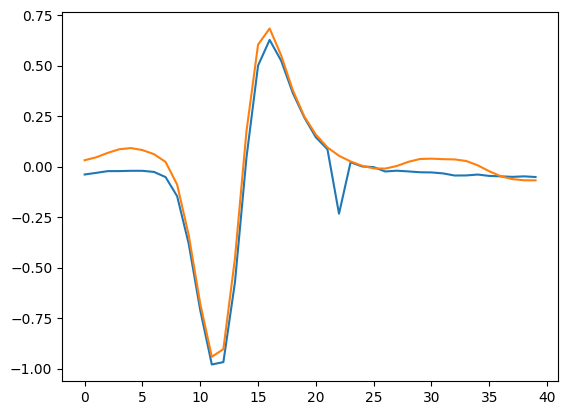

In [ ]:
s = 79
print(labels[s])
plt.plot(latent_space[s])
plt.plot(all_waveforms[s])
plt.show()

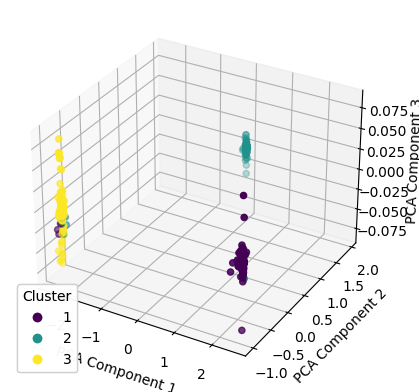

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# Perform PCA on the latent space
pca = PCA(n_components=3)
pca_latent_space = pca.fit_transform(latent_space)
# Plot the 3D domain and the cluster assignments
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_latent_space[:, 0], pca_latent_space[:, 1], pca_latent_space[:, 2], c=cluster_labels, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc='lower left', title='Cluster')
ax.add_artist(legend)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

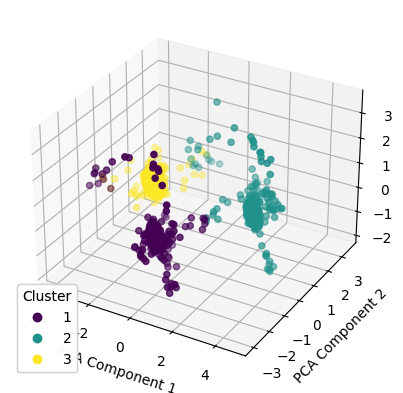

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# Perform PCA on the latent space
pca = PCA(n_components=3)
pca_latent_space = pca.fit_transform(all_waveforms)
# Plot the 3D domain and the cluster assignments
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_latent_space[:, 0], pca_latent_space[:, 1], pca_latent_space[:, 2], c=labels, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc='lower left', title='Cluster')
ax.add_artist(legend)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()